In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 12, 8

# Подготовка данных

## Загрузка данных

In [2]:
data = pd.read_csv('train.csv')
data = data.astype({'Rooms': int, 'HouseFloor': int, 'DistrictId': str})
data.set_index('Id', inplace=True)

check = pd.read_csv('test.csv')
check = check.astype({'Rooms': int, 'HouseFloor': int, 'DistrictId': str})

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
DistrictId       10000 non-null object
Rooms            10000 non-null int32
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null int32
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(6), int32(2), int64(7), object(4)
memory usage: 1.4+ MB


## Выявляю слабые признаки

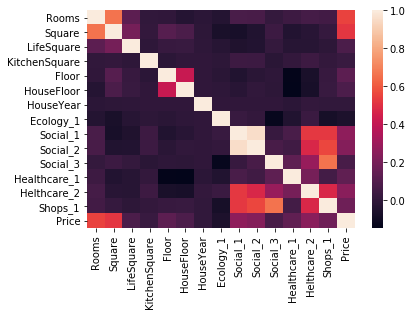

In [4]:
sns.heatmap(data.corr())

Social_1 и Social_2 коррелируют, оставляю один

      Rooms    Square  LifeSquare  KitchenSquare     Floor  HouseFloor  \
0  0.265880  0.309015   -0.003216            0.0  0.078698    0.054244   
1  0.265392  0.308537   -0.002216            0.0  0.078087    0.053767   
2  0.264502  0.307834   -0.000538            0.0  0.077103    0.053012   
3  0.263026  0.307066   -0.000000            0.0  0.075504    0.051776   
4  0.260671  0.306039   -0.000000            0.0  0.073033    0.049716   
5  0.256997  0.304068    0.000000            0.0  0.069169    0.046571   
6  0.251840  0.300278    0.000000            0.0  0.062943    0.041930   
7  0.244204  0.292931    0.000000            0.0  0.052566    0.033850   
8  0.232932  0.278527    0.000000            0.0  0.035689    0.016481   
9  0.210730  0.259416    0.000000            0.0  0.004100    0.000000   

   HouseYear  Ecology_1  Social_1  Social_3  Healthcare_1  Helthcare_2  \
0   0.029515  -0.003633  0.069752  0.032940      0.039066     0.019319   
1   0.028842  -0.003231  0.066686  0.

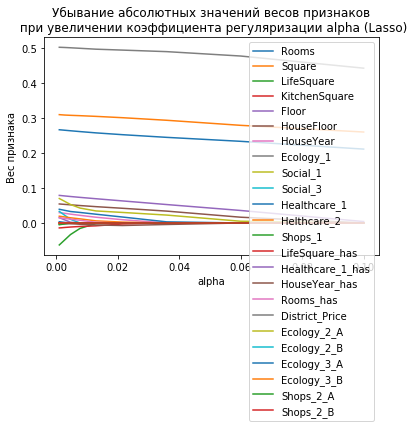

In [5]:
from sklearn.linear_model import Lasso

df = data.copy()

df = df.drop('Social_2', axis=1)
df['LifeSquare_has'] = pd.isnull(df['LifeSquare']) | (df['LifeSquare']==0)
df['LifeSquare'].fillna(0, inplace=True)
df['Healthcare_1_has'] = pd.isnull(df['Healthcare_1']) | (df['Healthcare_1']==0)
df['Healthcare_1'].fillna(-1, inplace=True)
df['HouseYear_has'] = (df['HouseYear']>2020) | (df['HouseYear']==1977)
df.loc[(df['HouseYear']>2020) | (df['HouseYear']==1977), 'HouseYear'] = 1977
df['Rooms_has'] = df['Rooms']==0

District_Price = df.groupby('DistrictId', as_index=False)['Price'].mean().rename(columns={'Price': 'District_Price'})
df = pd.merge(df, District_Price, on=['DistrictId'], how='left')

df.drop("DistrictId", axis=1, inplace=True)
df = pd.get_dummies(df)
df /= df.std(axis=0)

n = 10
features = df.drop(['Price'], axis=1).columns

coeffs = np.zeros((n, len(features)))
alpha_list = np.logspace(-3, -1, n)

for i, val in enumerate(alpha_list):
    lasso = Lasso(alpha=val)
    lasso.fit(df.loc[:, features], df['Price'])
    
    coeffs[i, :] = lasso.coef_.flatten()

for i in range(len(features)):
    plt.plot(alpha_list, coeffs[:, i])

plt.title('Убывание абсолютных значений весов признаков\n при увеличении коэффициента регуляризации alpha (Lasso)')

plt.xlabel('alpha')
plt.ylabel('Вес признака')

plt.legend(features)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame(data=coeffs, columns=features))

```
good: 'Rooms', 'Square', 'Floor', 'District_Price'
9: 'HouseFloor', 'Social_1'
8: 'Healthcare_1', HouseYear_has
7: 'HouseYear', 'Helthcare_2', 'LifeSquare_has'
6: 'Shops_1', 'Rooms_has'
5: 
4: 'Ecology_1', 'Social_3', 'Healthcare_1_has', 'Shops_2'
3: 'LifeSquare', 'Ecology_3'
2: 'Ecology_2'
1: 'KitchenSquare'

Social, Ecology, Shops сильно упали после добавления District_Price
Healthcare_1 хорошо показывает себя даже не смотря на дырки в данных
HouseYear_has хорошо дополняет HouseYear
```

## Очистка данных обучения

In [6]:
def fix_year(df):
#     df.loc[10814, 'HouseYear'] = 2008# 0.733095852077577
#     df.loc[11607, 'HouseYear'] = 1968# 0.7471282954700585
    df.drop(df[df['HouseYear']>2020].index, inplace=True)# 0.7760878488889289
    return df

def fix_rooms(df):
    df.loc[df['Rooms']>5, 'Rooms'] = None
    df.loc[df['Rooms']==0, 'Rooms'] = None
    df['Rooms'].fillna(1, inplace=True)
    return df

def fix_square(df):
#     df.loc[2307, 'Square'] = 40.9425181
#     df.loc[28, 'Square'] = 60.4705972
#     df.loc[11602, 'Square'] = 64.1065193
    return df

def fix_floor(df):
#     df = df.drop(28)
    return df

def fix_house_floor(df):
    df.loc[df['HouseFloor']>80, 'HouseFloor'] = 0
    return df

def fix_healthcare(df):
    df['Healthcare_1'].fillna(-1, inplace=True)
    return df

def fix_data(df):
    df = fix_year(df)
    df = fix_rooms(df)
    df = fix_square(df)
    df = fix_floor(df)
    df = fix_house_floor(df)
    df = fix_healthcare(df)
    return df

In [7]:
features = ['Rooms','Square','Floor','HouseFloor','HouseYear','Social_1','Healthcare_1']
df = data[features + ['DistrictId','Price']]

# rooms > 6
df = df.drop(5927)
df = df.drop(8491)
df = df.drop(14003)
df = df.drop(14865)
# rooms = 0
df = df.drop(12638)
df = df.drop(7917)
df = df.drop(7317)
df = df.drop(770)
df = df.drop(456)
df = df.drop(3224)
df = df.drop(3159)
df = df.drop(9443)
# square
df = df.drop(2307)
df = df.drop(28)
df = df.drop(11602)
# floor
df.loc[4698, 'Floor'] = 7

df = fix_data(df)

## Добавление искусственных признаков

In [8]:
District_Price = df.groupby('DistrictId', as_index=False)['Price'].mean().rename(columns={'Price': 'District_Price'})
df = pd.merge(df, District_Price, on=['DistrictId'], how='left')
# features.append("District_Price")

df['HouseYear_has'] = (df['HouseYear']==1977)
# features.append("HouseYear_has")

# df['IsFirst'] = (df['Floor']==1)
# features.append("IsFirst")
# df.drop("Floor", axis=1, inplace=True)

# df['IsLast'] = (df['Floor']>=df['HouseFloor'])
# features.append("IsLast")
# df.drop("HouseFloor", axis=1, inplace=True)

# df['LifeSquare'].fillna(0, inplace=True)
# df['LifeSquare_has'] = (df['LifeSquare']==0)
# df.drop("LifeSquare", axis=1, inplace=True)

# df['Healthcare_1_has'] = (df['Healthcare_1']==-1)

# df = df.astype({'Rooms': str})

df.drop("DistrictId", axis=1, inplace=True)
df = pd.get_dummies(df)

## Разбиваю выборки

In [9]:
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Масштабирование признаков

# Обучение

In [15]:
parameters = [{
    'n_estimators': [900],
    'max_features': [3],
    'max_depth': [15],
    'min_samples_leaf': [1],
    'min_samples_split': [3]
}]

clf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, criterion='mae'),
    param_grid=parameters,
    scoring='r2',
    cv=3,
    n_jobs=4
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
r2_score(y_test, y_pred)

0.771683935651223

In [14]:
clf.best_params_

{'max_depth': 15,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 900}

# Предсказание

In [21]:
df = check[features + ['DistrictId']]
df = fix_data(df)

df = pd.merge(df, District_Price, on=['DistrictId'], how='left')
mean_district_price = District_Price['District_Price'].mean()
df['District_Price'].fillna(mean_district_price, inplace=True)

df['HouseYear_has'] = (df['HouseYear']==1977)

df.drop("DistrictId", axis=1, inplace=True)

check['Price'] = clf.predict(df)

In [22]:
check.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2,49.882643,33.432782,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,150668.582345
1,15856,74,2,69.263183,NaN,1.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,231398.092158
2,5480,190,1,13.597819,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,247131.918666
3,15664,47,2,73.046609,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,271414.491756
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A,141546.010814


In [27]:
result = check[['Id', 'Price']]
result.to_csv('DMyachkov.csv', index=None)